In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from njit_funcs_recursive_grid import *
from backtest import backtest
from plotting import plot_fills, make_table
from downloader import Downloader, load_hlc_cache
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    create_xk,
    round_dynamic,
    round_values,
    sort_dict_keys,
)
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

using numba
using numba
using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [4]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/myconfig_v02.hjson"
        self.exchange = "bitget"
        self.symbols = "TRBUSDT"
        self.market_type = "futures"
        self.user = "bitget_01"
        self.start_date = "2023-10-13"
        self.end_date = "2023-10-16"
        self.starting_balance = 1000.0
        self.starting_configs = ""
        self.base_dir = "backtests"
        self.ohlcv = "y"  # set to "n" to use 1s candles


config = prepare_backtest_config(Args())

config["adg_n_subdivisions"] = 20  # see configs/backtest/default.hjson for details
config["inverse"] = False
sts = time()
if config["ohlcv"]:
    data = await load_hlc_cache(
        config["symbol"],
        config["inverse"],
        config["start_date"],
        config["end_date"],
        base_dir=config["base_dir"],
        spot=config["spot"],
        exchange=config["exchange"],
    )
    prices = data[:, 3]
    highs = data[:, 1]
    lows = data[:, 2]
    closes = data[:, 3]
else:
    downloader = Downloader(config)
    data = await downloader.get_sampled_ticks()
    prices = data[:, 2]
    highs = data[:, 2]
    lows = data[:, 2]
    closes = data[:, 2]
timestamps = data[:, 0]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings for TRBUSDT...
TRBUSDT most n days of consecutive identical ohlcvs: 0.000, index last: 0
millis to load 4320 ticks 2ms


<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

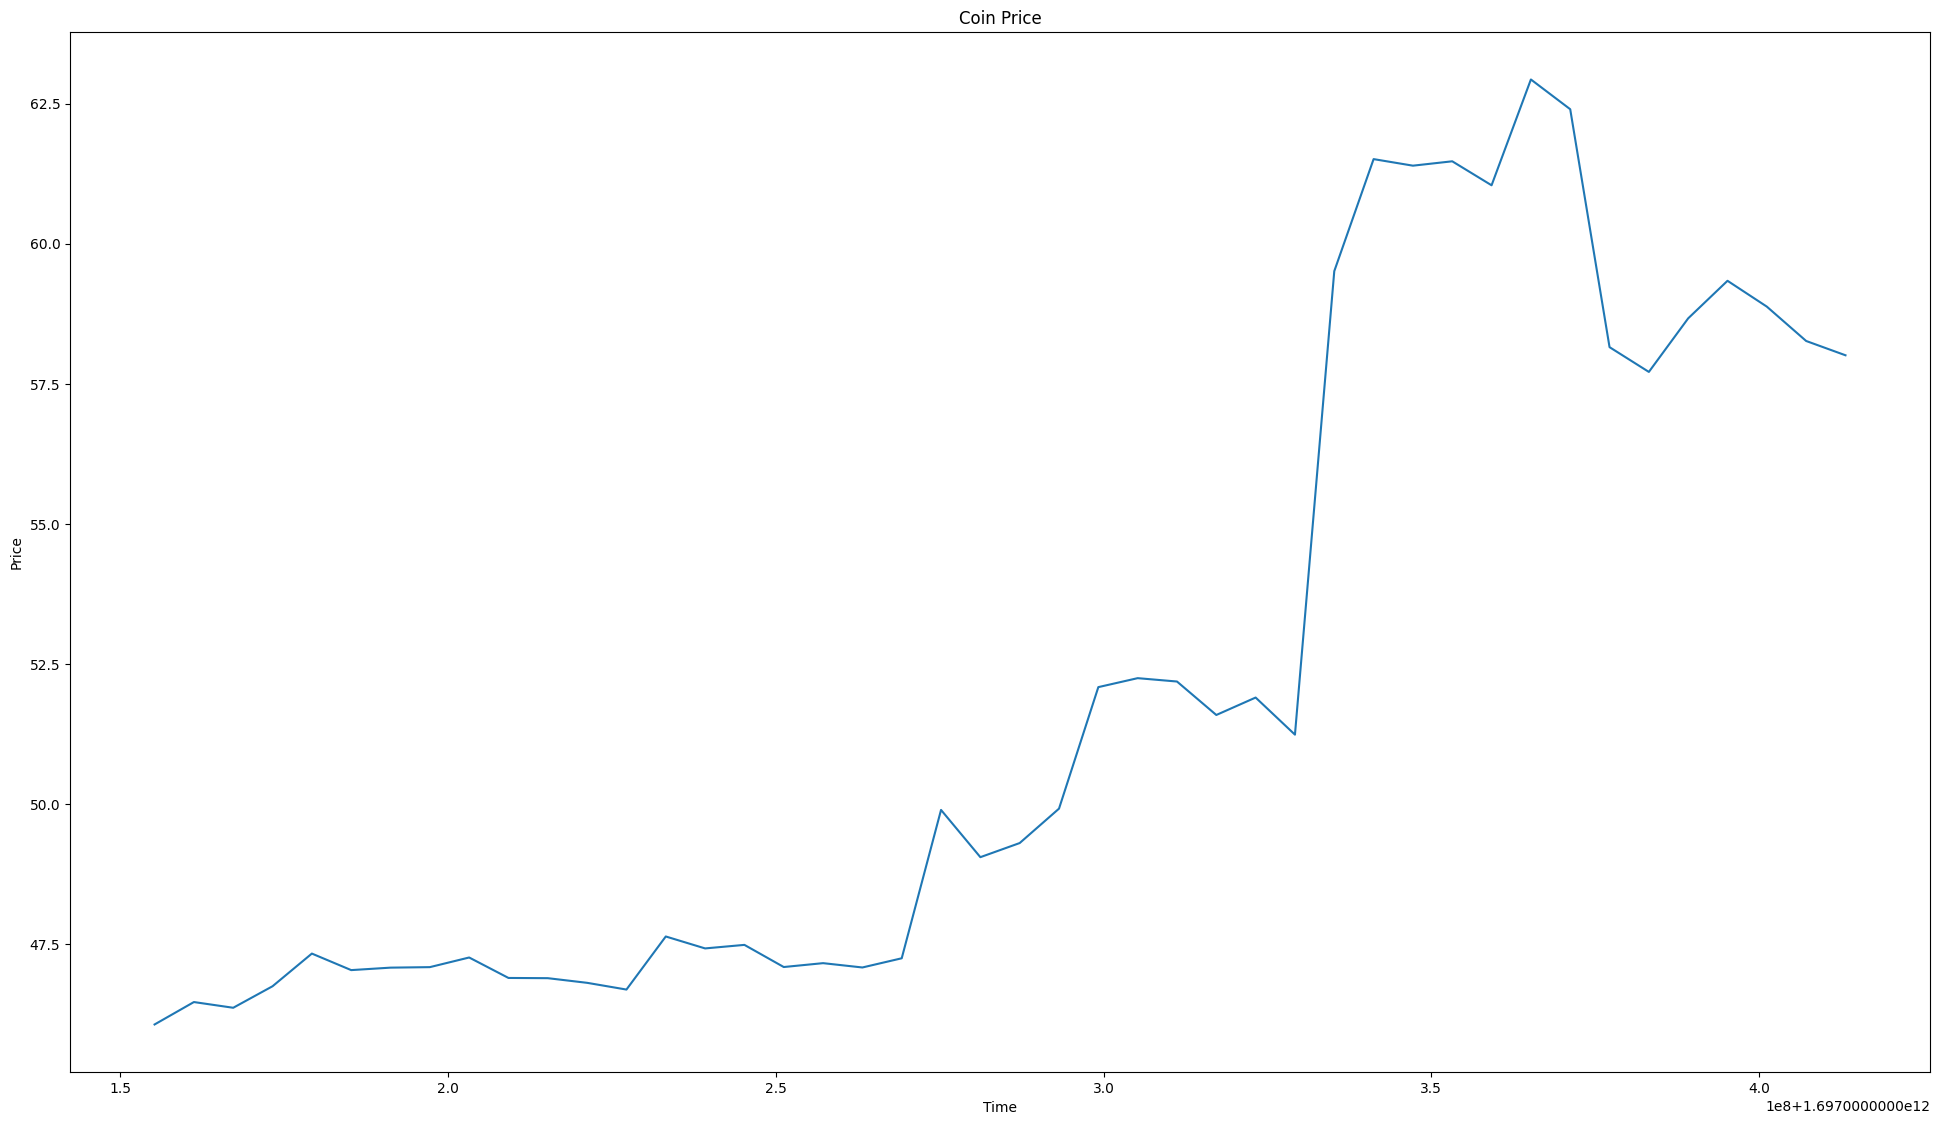

In [5]:
df = pd.DataFrame({"timestamp": timestamps, "price": prices}).set_index("timestamp")
df.price.iloc[::100].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [6]:
# choose a slice on which to test
wsize_days = 3650
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]
len(dataslice)

4320

In [7]:
custom_tuned = {
    "long":
        {
            "auto_unstuck_ema_dist": -0.03873483086285913,
            "auto_unstuck_wallet_exposure_threshold": 0.05913245621339072,
            "backwards_tp": True,
            "ddown_factor": 0.9663971682907846,
            "ema_span_0": 978.9440265702858,
            "ema_span_1": 1173.5898790671702,
            "enabled": True,
            "initial_eprice_ema_dist": 0.004,
            "initial_qty_pct": 0.02446427054013184,
            "markup_range": 0.01,
            "min_markup": 0.008540442504828518,
            "n_close_orders": 4.138115775049637,
            "rentry_pprice_dist": 0.030052654239696483,
            "rentry_pprice_dist_wallet_exposure_weighting": 11.18830873089761,
            "wallet_exposure_limit": 2
        },
    "short":
        {
            "auto_unstuck_ema_dist": 0.003,
            "auto_unstuck_wallet_exposure_threshold": 0.03614448454100035,
            "backwards_tp": True,
            "ddown_factor": 0.5909176560534417,
            "ema_span_0": 465.9268827189821,
            "ema_span_1": 623.1580630663296,
            "enabled": True,
            "initial_eprice_ema_dist": -0.0014719870386391079,
            "initial_qty_pct": 0.07142909087153279,
            "markup_range": 0.010541365857953094,
            "min_markup": 0.005403811055924777,
            "n_close_orders": 8.404989017720261,
            "rentry_pprice_dist": 0.024450503837829943,
            "rentry_pprice_dist_wallet_exposure_weighting": 4.358998913087744,
            "wallet_exposure_limit": 2
        }
}

In [8]:
hand_tuned = {
    "long":
    {
        "auto_unstuck_delay_minutes": 1000.0,
        "auto_unstuck_ema_dist": 0.001,
        "auto_unstuck_qty_pct": 0.04,
        "auto_unstuck_wallet_exposure_threshold": 0.15,
        "backwards_tp": True,
        "ddown_factor": 0.6,
        "ema_span_0": 700,
        "ema_span_1": 1440,
        "enabled": True,
        "initial_eprice_ema_dist": -0.02,
        "initial_qty_pct": 0.01,
        "markup_range": 0.018,
        "min_markup": 0.002,
        "n_close_orders": 16,
        "rentry_pprice_dist": 0.015,
        "rentry_pprice_dist_wallet_exposure_weighting": 15,
        "wallet_exposure_limit": 1.0
    },
    "short":
    {
        "auto_unstuck_delay_minutes": 1000.0,
        "auto_unstuck_ema_dist": 0.001,
        "auto_unstuck_qty_pct": 0.04,
        "auto_unstuck_wallet_exposure_threshold": 0.05,
        "backwards_tp": True,
        "ddown_factor": 0.19,
        "ema_span_0": 1440,
        "ema_span_1": 2880,
        "enabled": True,
        "initial_eprice_ema_dist": 0.02,
        "initial_qty_pct": 0.01,
        "markup_range": 0.018,
        "min_markup": 0.002,
        "n_close_orders": 16,
        "rentry_pprice_dist": 0.015,
        "rentry_pprice_dist_wallet_exposure_weighting": 23,
        "wallet_exposure_limit": 1.0
    }
}
# config_to_test = {**config, **hand_tuned}
config_to_test = {**config, **custom_tuned}

In [10]:
grid_long = calc_recursive_entries_long(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test["inverse"],
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["long"]["initial_qty_pct"],
    config_to_test["long"]["initial_eprice_ema_dist"],
    config_to_test["long"]["ddown_factor"],
    config_to_test["long"]["rentry_pprice_dist"],
    config_to_test["long"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["long"]["wallet_exposure_limit"],
    config_to_test["long"]["auto_unstuck_ema_dist"],
    config_to_test["long"]["auto_unstuck_wallet_exposure_threshold"],
    config_to_test["long"]["auto_unstuck_delay_minutes"]
    or config_to_test["long"]["auto_unstuck_qty_pct"],
    whole_grid=True,
)

grid_short = calc_recursive_entries_short(
    Args().starting_balance,
    0.0,
    0.0,
    df.price.iloc[-1],
    df.price.iloc[-1],
    config_to_test["inverse"],
    config_to_test["qty_step"],
    config_to_test["price_step"],
    config_to_test["min_qty"],
    config_to_test["min_cost"],
    config_to_test["c_mult"],
    config_to_test["short"]["initial_qty_pct"],
    config_to_test["short"]["initial_eprice_ema_dist"],
    config_to_test["short"]["ddown_factor"],
    config_to_test["short"]["rentry_pprice_dist"],
    config_to_test["short"]["rentry_pprice_dist_wallet_exposure_weighting"],
    config_to_test["short"]["wallet_exposure_limit"],
    config_to_test["short"]["auto_unstuck_ema_dist"],
    config_to_test["short"]["auto_unstuck_wallet_exposure_threshold"],
    config_to_test["short"]["auto_unstuck_delay_minutes"]
    or config_to_test["short"]["auto_unstuck_qty_pct"],
    whole_grid=True,
)

gdf_long = pd.DataFrame(
    grid_long, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_long.loc[:, "eprice_pprice_diff"] = abs(gdf_long.price - gdf_long.pprice) / gdf_long.price
gdf_long.loc[:, "ddown_factor"] = gdf_long.qty / gdf_long.psize.shift()
gdf_long.loc[:, "bkr_price"] = gdf_long.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)
gdf_short = pd.DataFrame(
    grid_short, columns=["qty", "price", "type", "psize", "pprice", "wallet_exposure"]
)
gdf_short.loc[:, "eprice_pprice_diff"] = abs(gdf_short.price - gdf_short.pprice) / gdf_short.price
gdf_short.loc[:, "ddown_factor"] = gdf_short.qty / gdf_short.psize.shift()
gdf_short.loc[:, "bkr_price"] = gdf_short.apply(
    lambda x: calc_bankruptcy_price(
        Args().starting_balance,
        x.psize,
        x.pprice,
        0.0,
        0.0,
        config_to_test["inverse"],
        config_to_test["c_mult"],
    ),
    axis=1,
)

# Display grid on graph
n_ticks = 60 * 60 * 24 * 14  # 14 days
dfx = pd.DataFrame(
    {
        "timestamp": pd.to_datetime(timestamps[-n_ticks:], unit="ms"),
        "price": prices[-n_ticks:],
    }
).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
fig = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=180) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
if config_to_test["long"]["enabled"]:
    for i, e in enumerate(gdf_long.itertuples()):
        fig.axhline(y=e.price, color="b", linestyle="-")
    print(f"\nGrid Span Long = {-(gdf_long.price.iloc[-1] / gdf_long.price.iloc[0] - 1) * 100:.2f}%")

if config_to_test["short"]["enabled"]:
    for i, e in enumerate(gdf_short.itertuples()):
        fig.axhline(y=e.price, color="r", linestyle="-")
    print(f"Grid Span Short = {(gdf_short.price.iloc[-1] / gdf_short.price.iloc[0] - 1) * 100:.2f}%")

pd.concat([gdf_long, gdf_short]).sort_values("price", ascending=False)

KeyError: 'auto_unstuck_delay_minutes'

In [ ]:
sts = time()
fills_long, fills_short, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test)
table = make_table({**config_to_test, **analysis})
print(table)

In [ ]:
sdf

In [ ]:
sdf.balance_long.plot()
sdf.equity_long.plot(title="Balance and equity long", xlabel="Time", ylabel="Balance")

In [ ]:
sdf.balance_short.plot()
sdf.equity_short.plot(title="Balance and equity short", xlabel="Time", ylabel="Balance")

In [ ]:
if len(longs) > 0:
    plot_fills(df, longs, plot_whole_df=True, title="Overview Fills Long")

In [ ]:
if len(shorts) > 0:
    plot_fills(df, shorts, plot_whole_df=True, title="Overview Fills Short")

In [ ]:
wes = pd.DataFrame(
    {"WE_short": (sdf.wallet_exposure_short.abs() * -1), "WE_long": sdf.wallet_exposure_long}
)
wes.plot(title="Wallet exposures", xlabel="Time", ylabel="Wallet Exposure")

In [ ]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf[sdf.psize_long != 0].pprice_long.replace(0.0, np.nan).plot()
sdf[sdf.psize_short != 0].pprice_short.replace(0.0, np.nan).plot()

In [ ]:
lpprices = sdf[sdf.psize_long != 0.0]
spprices = sdf[sdf.psize_short != 0.0]

PADistance_long = (lpprices.pprice_long - lpprices.price).abs() / lpprices.price
PADistance_short = ((spprices.pprice_short - spprices.price).abs() / spprices.price) * -1
print(f"Mean price action distance long {PADistance_long.mean():.6f} std {PADistance_long.std():.6f}")
print(f"Mean price action distance short {PADistance_short.mean():.6f} std {PADistance_short.std():.6f}")

PADistance_long.plot()
PADistance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

In [ ]:
# Inspect long EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["long"]["ema_span_0"],
    (config_to_test["long"]["ema_span_0"] * config_to_test["long"]["ema_span_1"]) ** 0.5,
    config_to_test["long"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)

spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["long"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["long"]["auto_unstuck_ema_dist"])
long_ientry_band = ema_band_lower * (1 - config_to_test["long"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(
    style="b--",
)
unstucking_band_upper.iloc[::100].plot(style="r--")
long_ientry_band.iloc[::100].plot(style="g-.")

In [ ]:
# Inspect short EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["short"]["ema_span_0"],
    (config_to_test["short"]["ema_span_0"] * config_to_test["short"]["ema_span_1"]) ** 0.5,
    config_to_test["short"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)

spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["short"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["short"]["auto_unstuck_ema_dist"])
short_ientry_band = ema_band_upper * (1 + config_to_test["short"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(style="b--")
unstucking_band_upper.iloc[::100].plot(style="r--")
short_ientry_band.iloc[::100].plot(style="g-.")